In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [5]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [6]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"Column: {col} is categorical")
    else:
        print(f"Column: {col} is numerical")

Column: engine_displacement is numerical
Column: num_cylinders is numerical
Column: horsepower is numerical
Column: vehicle_weight is numerical
Column: acceleration is numerical
Column: model_year is numerical
Column: origin is categorical
Column: fuel_type is categorical
Column: drivetrain is categorical
Column: num_doors is numerical
Column: fuel_efficiency_mpg is numerical


In [12]:
for col in df.columns:
    if df[col].dtype == 'object':
        #print(f"Column: {col} is categorical")
        print(df[col].value_counts())

origin
europe    3254
asia      3247
usa       3203
Name: count, dtype: int64
fuel_type
gasoline    4898
diesel      4806
Name: count, dtype: int64
drivetrain
all-wheel_drive      4876
front-wheel_drive    4828
Name: count, dtype: int64


In [11]:
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype(str).str.lower().str.replace(" ", "_")

In [14]:
 for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('NA')
        else:
            df[col] = df[col].fillna(0.0)

In [15]:
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [17]:
target = "fuel_efficiency_mpg"

# Step 1: Split 60/40 first → train_temp and test_temp
df_full_train, df_test = train_test_split(df, test_size=0.4, random_state=1)

# Step 2: Split the 40% into 20/20 (half of it)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1)

print(f"Train: {len(df_full_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

# Step 3: Separate features and target
y_train = df_full_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

# Drop the target column from the features
del df_full_train[target]
del df_val[target]
del df_test[target]

# Step 4: Convert to dictionaries
train_dicts = df_full_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

# Step 5: Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

print("Feature matrix shapes:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: 5822, Validation: 1941, Test: 1941
Feature matrix shapes:
Train: (5822, 14)
Validation: (1941, 14)
Test: (1941, 14)


# Question 1

Let's train a decision tree regressor to predict the fuel_efficiency_mpg variable.

- Train a model with max_depth=1.
- Which feature is used for splitting the data?

'vehicle_weight'
'model_year'
'origin'
'fuel_type'

In [24]:
# Train a simple decision tree with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Check which feature was used for splitting
feature_index = dt.tree_.feature[0]
split_feature = dv.get_feature_names_out()[feature_index]
threshold = dt.tree_.threshold[0]

print(f"The feature used for splitting is: {split_feature}")
print(f"The threshold value is: {threshold:.4f}")

The feature used for splitting is: vehicle_weight
The threshold value is: 3028.8232


# Question 2

Train a random forest regressor with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

- 0.045
- 0.45
- 4.5
- 45.0

In [26]:
# Train the Random Forest
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1  # use all cores for faster training
)
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.4603


# Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

If it doesn't stop improving, use the latest iteration number in your answer.

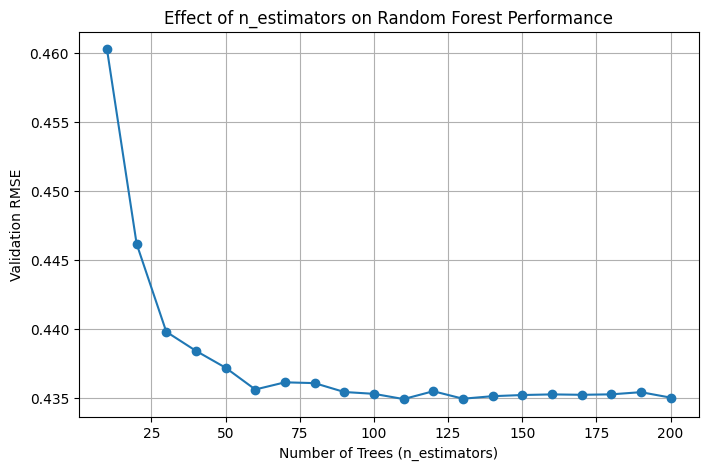

In [27]:
# Range of n_estimators to test
n_values = range(10, 201, 10)

rmse_scores = []

for n in n_values:
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(n_values, rmse_scores, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Validation RMSE")
plt.title("Effect of n_estimators on Random Forest Performance")
plt.grid(True)
plt.show()

Answer: 80

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]

For each of these values,
- try different values of n_estimators from 10 till 200 (with step 10)
- calculate the mean RMSE
- Fix the random seed: random_state=1


What's the best max_depth, using the mean RMSE?

10
15
20
25


Validation RMSE for Random Forest (rows=max_depth, columns=n_estimators):
      10     20     30     40     50     60     70     80     90     100  \
10  0.451  0.443  0.438  0.437  0.436  0.435  0.435  0.435  0.435  0.435   
15  0.462  0.447  0.441  0.439  0.437  0.436  0.436  0.436  0.435  0.435   
20  0.460  0.445  0.440  0.439  0.437  0.436  0.436  0.436  0.436  0.435   
25  0.461  0.447  0.440  0.439  0.437  0.436  0.436  0.436  0.435  0.435   

      110    120    130    140    150    160    170    180    190    200  
10  0.434  0.434  0.434  0.434  0.435  0.435  0.434  0.434  0.434  0.434  
15  0.435  0.435  0.435  0.435  0.435  0.435  0.435  0.435  0.436  0.435  
20  0.435  0.435  0.435  0.435  0.435  0.436  0.436  0.436  0.436  0.435  
25  0.435  0.435  0.435  0.435  0.435  0.435  0.435  0.435  0.435  0.435  


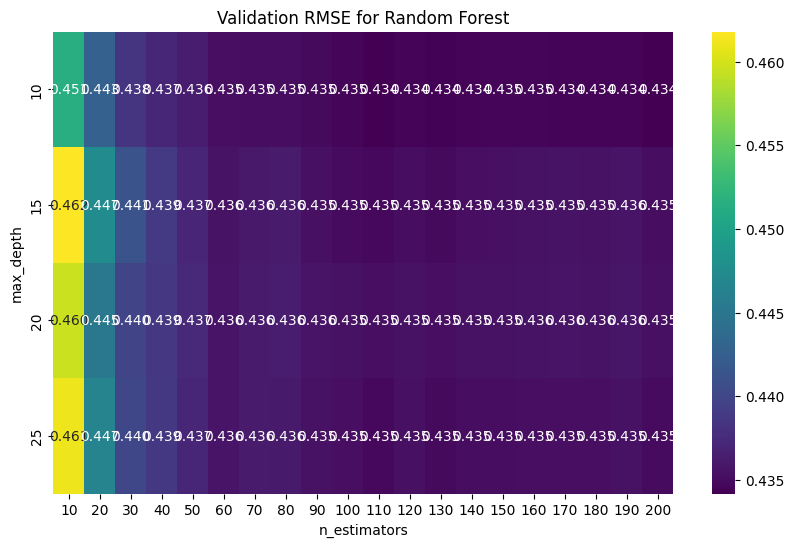

In [29]:
# Define parameter ranges
max_depth_values = [10, 15, 20, 25]
n_estimators_values = range(10, 201, 10)

# Create an empty table to store RMSE results
results = pd.DataFrame(index=max_depth_values, columns=n_estimators_values)

# Loop over both parameters
for max_depth in max_depth_values:
    for n in n_estimators_values:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=max_depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results.loc[max_depth, n] = rmse

# Convert to numeric values
results = results.astype(float)

# Display as a table
print("Validation RMSE for Random Forest (rows=max_depth, columns=n_estimators):")
print(results.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis")
plt.title("Validation RMSE for Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

Answer: 10

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model
- What's the most important feature (among these 4)?

- vehicle_weight
- horsepower
- acceleration
- engine_displacement

In [32]:
# Train the model
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate (optional)
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.3f}")

# --- Feature importance ---
importances = rf.feature_importances_

# Create a dataframe for readability
feature_importance_df = pd.DataFrame({
    'feature': dv.get_feature_names_out(),   # use your DictVectorizer’s feature names
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature importances:")
print(feature_importance_df)

# --- Most important feature ---
most_important = feature_importance_df.iloc[0]
print(f"\nMost important feature: {most_important['feature']} (importance = {most_important['importance']:.3f})")

Validation RMSE: 0.460

Feature importances:
                         feature  importance
13                vehicle_weight    0.959878
6                     horsepower    0.015933
0                   acceleration    0.011442
3            engine_displacement    0.003159
7                     model_year    0.003066
8                  num_cylinders    0.002323
9                      num_doors    0.001576
12                    origin=usa    0.000496
10                   origin=asia    0.000431
11                 origin=europe    0.000419
4               fuel_type=diesel    0.000349
1     drivetrain=all-wheel_drive    0.000343
5             fuel_type=gasoline    0.000307
2   drivetrain=front-wheel_drive    0.000277

Most important feature: vehicle_weight (importance = 0.960)


Answer: vehicle_weight

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
- Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value

In [35]:
# --- Step 1: Create DMatrix for train and validation ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# --- Step 2: Common watchlist ---
watchlist = [(dtrain, 'train'), (dval, 'val')]

# --- Step 3: Define base parameters ---
base_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# --- Step 4: Try eta = 0.3 ---
params_eta_03 = base_params.copy()
params_eta_03['eta'] = 0.3

print("\nTraining with eta = 0.3 ...")
model_eta_03 = xgb.train(params_eta_03, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)

y_pred_03 = model_eta_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))
print(f"Validation RMSE (eta=0.3): {rmse_03:.4f}")

# --- Step 5: Try eta = 0.1 ---
params_eta_01 = base_params.copy()
params_eta_01['eta'] = 0.1

print("\nTraining with eta = 0.1 ...")
model_eta_01 = xgb.train(params_eta_01, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)

y_pred_01 = model_eta_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))
print(f"Validation RMSE (eta=0.1): {rmse_01:.4f}")

# --- Step 6: Compare ---
if rmse_01 < rmse_03:
    print("\n✅ eta = 0.1 gives the best RMSE!")
else:
    print("\n✅ eta = 0.3 gives the best RMSE!")



Training with eta = 0.3 ...
Validation RMSE (eta=0.3): 0.4434

Training with eta = 0.1 ...
Validation RMSE (eta=0.1): 0.4167

✅ eta = 0.1 gives the best RMSE!


Answer: eta=0.1